# Trabalho Prático Modulo Final

## Enunciado

O projeto visa explorar o potencial dos Conditional Variational Autoencoders (C-VAEs) para a geração de dados sintéticos baseados em classes específicas de imagens do dataset MNIST. O MNIST é um conjunto de dados composto por milhares de imagens de dígitos escritos à mão.

Para este trabalho prático, você desenvolverá uma C-VAEs para gerar novas imagens que se assemelhem aos dados originais. A C-VAEs será treinada para aprender as representações latentes dos dados e gerar amostras que imitam as características principais das imagens de entrada.

Será disponibilizado um Jupyter notebook (.ipynb) com o nome “trabalho_pratico_guia.ipynb” para auxiliar no desenvolvimento da C-VAE.

## Passo 1: Editar o script training_script.py disponibilizado
1. Construa o encoder (lembre que a entrada é uma imagem 28x28 Mnist)
2. Construa o decoder (a saída é também uma imagem 28x28)
3. Modifique predict_fn de modo que você realize uma predição sobre os dados de entrada.

Obs.: Os métodos predict_fn, input_fn, model_fn são utilizado pelo SageMaker endpoint para realizar a predição, tratar o input e carregar o modelo respectivamente.

## Criando um ambiente no SageMaker

1. Acesse o console da AWS e faça login como root
    > Caso não tenha uma conta na AWS crie uma nova conta.
    > Consulte o nível gratuito do SM [AQUI](https://aws.amazon.com/pt/pm/sagemaker/?gclid=CjwKCAjwl6-3BhBWEiwApN6_knt7Co9rU8YwhSbR4ePsaeYuzgex5QwFdWibp1jL53CM3YXZ5IT4EBoCoUkQAvD_BwE&trk=41368dcc-5040-4349-998b-a9c524544f65&sc_channel=ps&ef_id=CjwKCAjwl6-3BhBWEiwApN6_knt7Co9rU8YwhSbR4ePsaeYuzgex5QwFdWibp1jL53CM3YXZ5IT4EBoCoUkQAvD_BwE:G:s&s_kwcid=AL!4422!3!532488969034!e!!g!!sagemaker!12024811143!113992794377)
2. Nos serviços da AWS busque por SageMaker Studio e entre.
3. No Applications and IDEs -> Studio clique em *Create a SageMaker Domain*
4. Abra o studio criado e vá para JupyterLab e crie um novo espaço do JupyterLab
5. Depois de criado o espaço entre nele e na lateral direita superior clique em upload files e suba esse arquivo .ipynb e o training_script.py



## Importando bibliotecas necessárias


In [3]:
import sagemaker
import matplotlib.pyplot as plt


## Setup do bucket

Se você quiser usar um bucket S3 específico, use o código a seguir e substitua as strings pelo nome exato do bucket S3. O nome do bucket deve conter sagemaker e ser globalmente exclusivo. O bucket deve estar na mesma região da AWS que a instância de notebook usada neste exemplo.

Caso não queira criar seu próprio bucket para esse trabalho, o SageMaker vai criar um para você. Para isso remova o default_bucket do sagemaker.Session

In [4]:
bucket = "sagemaker-testets"

## Inicie a sessão do SageMaker

In [5]:
sagemaker_session = sagemaker.Session(default_bucket = bucket)

# Obtém o papel de execução do SageMaker (isso pode não funcionar fora do ambiente SageMaker)
role = sagemaker.get_execution_role()

region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/demo_mnist"

## Obtendo os dados MNIST

In [6]:
from torchvision import transforms
from torchvision.datasets import MNIST

# Carregando o dataset MNIST
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


## Subindo os dados para um S3 Bucket

In [7]:
# Sobe os dados da pasta "data" para o s3 bucket default
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-testets/sagemaker/demo_mnist


## Visualizando alguns dados

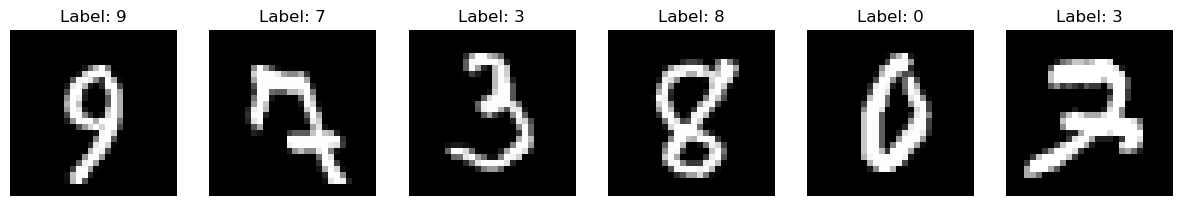

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Visualizando algumas imagens do dataset MNIST
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axs[i].imshow(example_data[i][0], cmap='gray')
    axs[i].set_title(f'Label: {example_targets[i].item()}')
    axs[i].axis('off')
plt.show()

## Subindo o primeiro estimator

In [30]:
# Verificando o script que será utilizado
!pygmentize training_script.py

import argparse
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import tqdm
import sys
import json
import numpy as np
import io
# from dotenv import load_dotenv


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


class ConditionalEncoder(nn.Module):
    def __init__(self, input_channels, num_classes, latent_dim):
        super(ConditionalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels + num_classes, 32, kernel_size=4, stride=2, padding=1)  # [batch_size, 32, 14, 14]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # [batch_size, 64, 7, 7]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # [batch_size, 128, 3, 3]
        self.flatten = nn.Flatten()  # Flatten para [batch_size, 128*3*3]
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.

In [18]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="training_script.py",
    role=role,
    py_version="py311",
    framework_version="2.3.0",
    instance_count=1,
    instance_type="ml.m4.xlarge", # coloque um modelo gratuito
    sagemaker_session=sagemaker_session
)

## Treinando o modelo

In [19]:
# Isso pode levar um tempo
estimator.fit({"training": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-09-09-16-37-09-689


2024-09-09 16:37:10 Starting - Starting the training job...
2024-09-09 16:37:39 Starting - Preparing the instances for training...
2024-09-09 16:38:03 Downloading - Downloading input data...
2024-09-09 16:38:38 Downloading - Downloading the training image.........
2024-09-09 16:39:54 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-09-09 16:40:09,360 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-09-09 16:40:09,360 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-09 16:40:09,361 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-09-09 16:40:09,370 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-09-09 16:40:09,372 sagemaker_pytorch_container.training INFO     Invoking user trai

## Deploy do modelo

In [16]:
estimator.model_data

's3://sagemaker-testets/pytorch-training-2024-09-09-15-55-30-277/output/model.tar.gz'

In [31]:
from sagemaker.pytorch import PyTorchModel

# Crie um objeto Model
model = PyTorchModel(
    entry_point="training_script.py",
    model_data=estimator.model_data,  # Caminho S3 para o modelo treinado
    # image_uri=estimator.image_uri,    # Imagem do contêiner usada para o treinamento
    role=role,
    sagemaker_session=sagemaker_session,
    framework_version='2.3.0', py_version='py311',
    env={
        "LATENT_DIM": "120",
        "NUM_CLASSES": "10",
        "INPUT_CHANNELS": "1"
    }
)

# Implemente o modelo em um endpoint
predictor = model.deploy(endpoint_name="test-endpoint-13", initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!

## Utilizando o endpoint

In [42]:
# chamando o endpoint, você pode fazer pelo teste direto do console se desejar
response = predictor.predict([1])

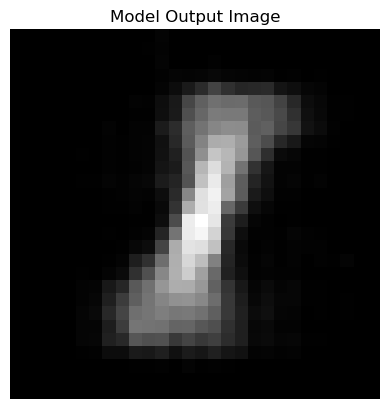

In [43]:
# Plote a imagem resultado
image = response.squeeze()  # Now it should be of shape (28, 28)

# Plotting the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.title('Model Output Image')  # Title for the plot
plt.show()

## Limpando o endpoint

In [ ]:
tuner.delete_endpoint()